<center>
<img src="https://camo.githubusercontent.com/ad20aaaa48264581c46aa126919dbb72060ebd98cffe015523549b4974843ae5/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f46556c79616e6b696e2f725f70726f626162696c6974792f6d61737465722f656e645f73656d696e6172732f73656d5f362f73747564656e745f746561636865725f646973742e706e67" height="200">

# Прикладаная статистика: домашнее задание 3
</center>

> Если орел — я выиграла, если решка — ты проиграл.

$\qquad$ Рейчел из друзей


**ФИО:** Куликов Дмитрий Алексеевич


## Общая информация


__Дата выдачи:__ 24.05.2023

__Дедлайн:__ 23:59MSK 11.06.2023

# Результаты A-B теста

В данном задании вам нужно будет проанализировать АБ тест, проведенный на реальных пользователях Яндекса.

### Описание данных:

* `userID` — уникальный идентификатор пользователя
* `browser` — браузер, который использовал userID
* `slot` — в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks` — количество кликов, которые пользоваль совершил за n_queries
* `n_queries` — количество запросов, который совершил userID, пользуясь браузером browser
* `n_nonclk_queries` — количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

In [161]:
df = pd.read_csv('data/ab_browser_test.csv',sep=',')

df['click_per_queries'] = df['n_clicks']/df['n_queries']
df['empty_query_share'] = df['n_nonclk_queries']/df['n_queries']

print(df.shape)
df.head()

(566134, 8)


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19,0.718750,0.593750
1,3,Browser #4,exp,3,4,2,0.750000,0.500000
2,5,Browser #4,exp,29,35,16,0.828571,0.457143
3,6,Browser #4,control,12,6,0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30,0.794118,0.441176


Будем работать с числом кликов на количество пользовательских сессий.

> Вообще, это ratio-метрика. Из-за этого у неё будут довольно тяжёлые хвосты. Мы увидим это ниже в пункте про бутстрэп. И к ней нужен особый подход, о котором мы поговорим на лекции. Пока что будем это игнорировать. В целом, можно откатиться к кликам и работать с их средним, но методологически правильнее отнормировать их на число сессий.

__[10 баллов]__ Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [8]:
n_clicks_control = df[df.slot == 'control'].n_clicks.values
n_clicks_exp = df[df.slot == 'exp'].n_clicks.values

In [162]:
(sum(n_clicks_exp) - sum(n_clicks_control)) / sum(n_clicks_control) * 100

1.6135689824415809

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

## Часть 1: анализ АБ-теста

__[10 баллов]__ Давайте мнимательнее посмотрим на то, что происходит с кликами в наших пользовательских сессиях. Постройте для контрольной и тестовой групп визуализации и ответьте на следующие вопросы.

- Правда ли, что в данных есть много выбросов?
- Правда ли, что данные пришли из одного распределения и в группах отличия только в сдвиге (для ответа на этот вопрос постройте для обеих групп квантили распределений с шагом в 0.1 и сравните их между собой + сравните гистограмы по форме)
- Как думаете, какие тесты применимы здесь для проведения АБ?

**Ответы:**



Пункт 1.

Чтобы определить, есть ли в данных выбросы, можно построить ящик с усами (boxplot) для каждой группы и визуально оценить наличие отдельных значений, выходящих за пределы "усов"

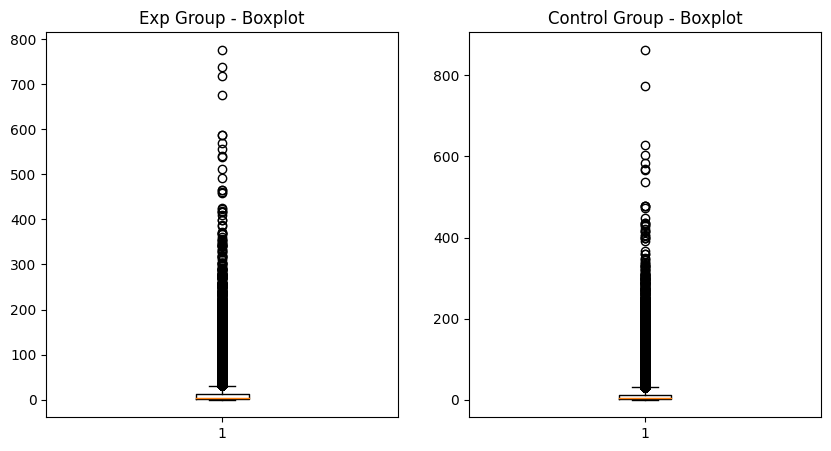

In [10]:
plt.figure(1, figsize = (10,5))

# Визуализация ящика с усами для группы exp
plt.subplot(1, 2, 1)
plt.boxplot(n_clicks_exp, showfliers=True)
plt.title('Exp Group - Boxplot')


# Визуализация ящика с усами для группы control
plt.subplot(1, 2, 2)
plt.boxplot(n_clicks_control, showfliers=True)
plt.title('Control Group - Boxplot')

plt.show()

Выбросов много

Пункт 2.

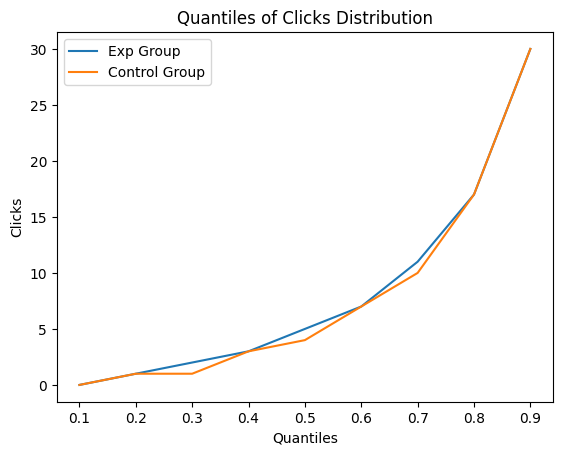

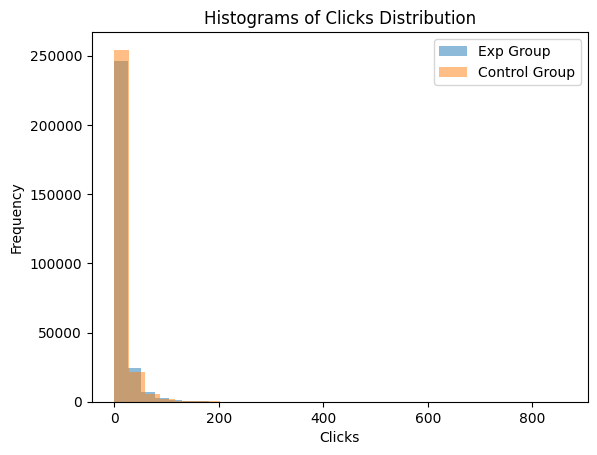

In [11]:
# Построение квантилей распределений
quantiles_exp = np.arange(0.1, 1, 0.1)
quantiles_control = np.arange(0.1, 1, 0.1)

quantile_exp_values = np.percentile(n_clicks_exp, quantiles_exp * 100)
quantile_control_values = np.percentile(n_clicks_control, quantiles_control * 100)

# Визуализация квантилей распределений
plt.plot(quantiles_exp, quantile_exp_values, label='Exp Group')
plt.plot(quantiles_control, quantile_control_values, label='Control Group')
plt.xlabel('Quantiles')
plt.ylabel('Clicks')
plt.legend()
plt.title('Quantiles of Clicks Distribution')
plt.show()

# Сравнение гистограмм распределений
plt.hist(n_clicks_exp, bins=30, alpha=0.5, label='Exp Group')
plt.hist(n_clicks_control, bins=30, alpha=0.5, label='Control Group')
plt.xlabel('Clicks')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histograms of Clicks Distribution')
plt.show()


В целом, квантили распределений совпадают и гистограммы имеют схожую форму, можно предположить, что данные пришли из одного распределения, и отличия между группами обусловлены только сдвигом.

Тесты которые можно было бы применить применимые здесь для проведения АБ:
1. t-тест (независимые выборки). Используется для сравнения средних значений между двумя независимыми группами. Надо убедится, что данные распределены нормально или приближенно к нормальному распределению. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных. Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.
2. Z-тест (независимые выборки) провести не можем из за присутствия выбросов.
3. Одним из возможных аналогов t-критерия, которым можно воспользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

__[10 баллов]__ Скорее всего, в пункте выше вы написали, что $z$-тест нам не подходит из-за выбросов. Однако, мы не можем наверняка знать, насколько серьёзное влияние эти выбросы оказали на ЦПТ и сломали ли они её. Если посчитать по выброкам средние и медианы, они окажутся очень похожими.

Бутстрап — это асимптотическая техника для получения критических значений статистики. Давайте проведём следующую процедуру. Ограничимся в рамках неё контрольной группой. Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстрэп, чтобы понять, как распределена z-статистика и сравнить её распределение с нормальным.

Поскольку мы знаем, что $\text{Var}(\bar X_n) = \frac{\sigma^2}{n}$, нам не надо будет делать бутстрэп в бутстрэпе. Когда мы знаем для нашей статистики форму дисперсии, бутстрэп называется __параметрическим.__

1. Получите из данных `n_boot_samples` псевдовыборок,
2. По каждой из этих выборок посчитайте среднее и его дисперсию,
3. Рассчитайте значение $z$-статистики,
4. Для получившегося вектора из $z$-статистик постройте `qq-plot` с помощью ` scipy.stats.probplot` для нормального распределения.

Сделайте выводы.

In [49]:
def get_boot_sample(x, B_sample=1):
    N = x.size
    sample = np.random.choice(x, size=(N, B_sample), replace=True)

    if B_sample == 1:
        sample = sample.T[0]
    return sample

In [163]:
click_queries_control = df[df.slot == 'control'].click_per_queries.values
click_queries_exp = df[df.slot == 'exp'].click_per_queries.values

In [ ]:
n_boot_samples = 500
np.random.seed(42)

In [ ]:
control_samples = get_boot_sample(click_queries_control, n_boot_samples)

In [ ]:
control_boot_mean = np.mean(control_samples, axis=0)
control_boot_std = np.std(control_samples, axis=0, ddof=1)

z_stats = (control_boot_mean - control_boot_mean.mean()) / control_boot_mean.std(ddof=1)

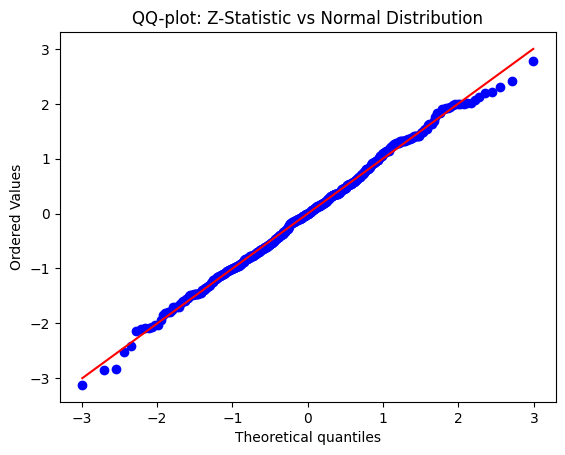

In [ ]:
# QQ-plot для сравнения z-статистик с нормальным распределением
sts.probplot(z_stats, dist='norm', plot=plt)
plt.title("QQ-plot: Z-Statistic vs Normal Distribution")
plt.show()

Исходя из QQ-графика, можно сделать выводы о сходстве распределения z-статистик и нормального распределения. Точки на графике совпадают с прямой, можно считать, что распределение z-статистик близко к нормальному. Хвосты распределения отличаются от стандартного нормального.

__[10 баллов]__ Осторожно, спойлеры! В прошлом пункте у вас получилась картинка, на которой хвосты распределения немного отличаются от стандартного нормального. Давайте сделаем вид, что всё хорошо и отличия на хвостах нет. Проверьте гипотезу о равенстве средних между группами с помощью $z-$теста на уровне значимости $1\%$.

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm} \text{Среднее число кликов не отличается} \\
&H_1: \hspace{2mm} \mu_1 \neq \mu_2  \hspace{2mm} \text{Среднее число кликов отличается}
\end{aligned}
$$

In [ ]:
from scipy.stats import ttest_ind

# Проведение z-теста
alpha = 0.01  # Уровень значимости

stat, p_value = ttest_ind(click_queries_control, click_queries_exp)
stat, p_value

(-27.560303837655056, 4.298537482643951e-167)

Т.к p_value < alpha то нулевая гипотеза отвергается, то есть среднее число лайков отличается

__[10 баллов]__ Давайте попробуем понять, какими при таких объёмах выборки оказываются MDE и ошибка второго рода. Конечно, же сделать это надо до проведения АБ-теста. Но не мы его готовили... При решении этого пункта выберите какое-то адекватное значение MDE и получите отталкиваясь от него ошибку второго рода.

Формула для расчета числа наблюдений __для одной группы:__

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [164]:
z_beta = np.sqrt(n_one_group * MDE**2 / (click_queries_control.var() + click_queries_exp.var())) - sts.norm.ppf(1 - alpha/2)

In [165]:
beta = 1 - sts.norm.cdf(z_beta)

In [166]:
beta

0.14237711254969598

__[10 баллов]__ Хвосты отличаются от стандартного нормального. По хорошему, для проверки гипотезы нужно использовать бутстрап. В контексте средних, на бутстрап можно смотреть как на технику, которая уточняет, насколько сильно хвосты распределения стали тяжелее по сравнению с ЦПТ.

Проверьте гипотезу с помощью бутстрапа! Воспользуйтесь следующим алгоритмом с лекции:

1. Посчитайте наблюдаемое значение статистики.
2. Пусть $\bar h$ - это среднее посчитанное по обеим выборкам вместе. Создайте две новые выборки $$x'_i = x_i - \bar x + \bar h \\ y'_i = y_i - \bar y + \bar h.$$ Такое рецентрирование сдвинет обе выборки к общему среднему и  позволит заложить в симуляцию информацию о верности нулевой гипотезы.
3. Сбутстрапируйте выборки $x^{*}$ и $y^{*}$ из $x'$ и $y'$. Рассчитайте значение z-статистики. Повторит процедуру $B$ раз.
4. Для оценки `p-value` воспользуйтесь формулой:

$$
2 * \frac{1}{B} \sum_{i=1}^B [z_i^{*} \ge z_{obs}]
$$

In [167]:
alpha

0.01

In [168]:
click_queries_exp_mean = np.mean(click_queries_exp)
click_queries_control_mean = np.mean(click_queries_control)
click_queries_exp_var = click_queries_exp.var(ddof=1)
click_queries_control_var = click_queries_control.var(ddof=1)
n_click_queries_exp = len(click_queries_exp)
n_click_queries_control = len(click_queries_control)

var_div_n_exp = click_queries_exp_var / n_click_queries_exp
var_div_n_control = click_queries_control_var / n_click_queries_control

std = np.sqrt(var_div_n_exp + var_div_n_control)

z_obs = (click_queries_exp_mean - click_queries_control_mean) / std

In [44]:
z_obs

27.55706066913807

In [45]:
z_crit = sts.norm.ppf(1-alpha/2)               # критическое значение статистики
z_crit

2.5758293035489004

In [135]:
n_boot_samples = 1000
B = 10

In [136]:
h_mean = df['click_per_queries'].mean()
exp_prime = click_queries_exp - click_queries_exp_mean + h_mean
control_prime = click_queries_control - click_queries_control_mean + h_mean

In [143]:
z_obs_boot = []
for _ in range(B):
  exp_samples = get_boot_sample(exp_prime, n_boot_samples)
  control_samples = get_boot_sample(control_prime, n_boot_samples)

  boot_exp_mean = np.mean(exp_samples, axis=0)
  boot_control_mean = np.mean(control_samples, axis=0)

  z_obs_boot.append((boot_control_mean.mean() - boot_exp_mean.mean()) / std)

In [144]:
p_value = 2 * np.mean(z_obs_boot >= z_obs)

In [145]:
p_value

0.0

Т.к p_value < alpha то нулевая гипотеза отвергается, то есть среднее число лайков отличается

In [146]:
bootstrap_critical_value = np.quantile(np.abs(z_obs_boot), 1 - alpha/2)
bootstrap_critical_value

0.0718460680745531

In [147]:
z_crit - bootstrap_critical_value

2.5039832354743474

__Ответьте на следующие вопросы:__

- Изменились ли выводы АБ-теста?
- Насколько сильно критическое значение статистики, полученной с помощью бутстрэпа, отличается от киритческого значения нормального распределения?
- Какую из ошибок (1 рода/2 рода) вы будете чаще совершать, если в ситуации с толстыми хвостами будете пользоваться нормальным распредеелнием? Насколько чаще будет возникать эта ошибка?

1. Выводы АБ-теста не изменились

2. Разница в критическом значений 2.5142841968713054
3.

Если в ситуации с тяжелыми хвостами (распределение с отличными от нормального хвостами) использовать нормальное распределение для статистических тестов, то в таком случае будет чаще возникать ошибка первого рода (ошибка при отвержении верной нулевой гипотезы).

При использовании нормального распределения для данных с тяжелыми хвостами мы не учитываем характеристики распределения, которые могут влиять на статистические тесты. Нормальное распределение предполагает легкие хвосты и симметричность, что не всегда соответствует действительности.

Использование нормального распределения в ситуации с тяжелыми хвостами может привести к недооценке риска ложноположительных результатов (ошибки первого рода) и, следовательно, к чаще возникновению этой ошибки. В таких случаях, следует использовать альтернативные методы, такие как непараметрические тесты или бутстрэп, которые лучше учитывают особенности распределения данных и не делают предположений о его форме.

__[10 баллов]__ Насколько больше наблюдений нам необходимо для проверки гипотезы по сравнению с z-тестом? Для ответа на этот вопрос подставьте критические значение из бустрап-распределения в формулу для оценки числа наблюдений. В качестве MDE возьмите величину, которую вы сами зафикисировали в прошлых пунктах. В качестве ошибки второго рода возьмите получившуюся при рассчётах величину.

In [174]:
np.abs(z_obs_boot)

array([0.00147565, 0.00161039, 0.06991619, 0.02822982, 0.0120821 ,
       0.04052042, 0.02291714, 0.071937  , 0.01850102, 0.05439871])

In [180]:
z_boot_beta = np.quantile(np.abs(z_obs_boot), 1 - beta)
z_boot_beta

0.06554966034293691

In [183]:
# Расчет числа наблюдений для одной группы
n_one_group_boot = (click_queries_control.var() + click_queries_exp.var()) * (bootstrap_critical_value + z_boot_beta)**2 / MDE**2

# Расчет общего числа наблюдений для АБ-теста
n_total_boot = 2 * n_one_group_boot

print("Число наблюдений для одной группы:", n_one_group_boot)
print("Общее число наблюдений для АБ-теста:", n_total_boot)


Число наблюдений для одной группы: 139890.72043503917
Общее число наблюдений для АБ-теста: 279781.44087007834


Тоесть нужно 279782 наблюдений

__[10 баллов]__ Проверьте ту же гипотезу тестом Манна-Уитни. Используйте для этого функцию `scipy.stats.mannwhitneyu`.

In [62]:
mw_obs, mw_pval = sts.mannwhitneyu(click_queries_control, click_queries_exp, alternative='two-sided')

print(f"Наблюдаемое значение: {mw_obs}")
print(f"P-значение: {mw_pval:.5}")

Наблюдаемое значение: 37765830709.5
P-значение: 1.2767e-307


 `pvalue < alpha=0.01` => H0 отвергается в пользу H1, т.е. среднее число кликов отличается.


При $n,m \to \infty$ статистика Манна-Уитни сходится к нормальному распределению со следующими параметрами:

$$
U \Rightarrow N \left( \frac{n_T \cdot n_C}{2}, \frac{n_T \cdot n_C \cdot (n_T + n_C + 1)}{12} \right)
$$

Отталкиваясь от этого приближения, определите сколько наблюдений нам необходимо для проверки гипотезы для тех же MDE и ошибки 2 рода, что и у z-теста/бустрапа.

Ахтунг! Решили что этот вопрос некорректен

__[10 баллов]__ У многих аналитиков с теста Манна-Уитни подгорает жепа. Это происходит из-за того, что на практике его часто используют довольно бездумно. [Вот один из свежих примеров бомбежа.](https://habr.com/ru/companies/avito/articles/709596/)

В нашем кейсе, если аккуратно посчитать квантили обоих распределений, можно увидеть, что в тестовой группе квантили и правда съехали вправо, а форма гистограмм не изменилась. В целом, это знак, что тест можно спокойно применять. Однако, квантили левее $0.1$ не поменялись.

Вместо тесто Манна-Уитни на сдвиг распределения, мы можем попробовать проверить гипотезу о том, что наше распределение, в принципе, как-то поменялось. Для таких гипотез обычно используются критерии согласия. Проверьте гипотезу о том, что распределения тестовой и контрольной групп совпадают с помощью теста Колмогорова-Смирнова `scipy.stats.ks_2sam`.

In [63]:
sts.ks_2samp(click_queries_control, click_queries_exp)

KstestResult(statistic=0.04512279635017363, pvalue=7.558755364350695e-251, statistic_location=0.7468354430379747, statistic_sign=1)

Насколько сильно друг от друга отличаются p-значения этих тестов? Как думаете, почему отличие именно такое?

__Ответ:__

Полученные p-значения для теста Манна-Уитни (1.2767e-307) и теста Колмогорова-Смирнова (7.558755364350695e-251) различаются значительно.

Отличие в p-значениях говорит о различной степени статистической значимости результатов этих двух тестов. Чем меньше p-значение, тем сильнее доказательства против нулевой гипотезы (гипотезы о совпадении распределений).

Различие в результате связано с особенностями и предпосылками каждого теста. Тест Манна-Уитни основан на рангах и оценивает сдвиг распределений, тогда как тест Колмогорова-Смирнова оценивает общую форму распределений. Поэтому результаты и интерпретация могут отличаться в зависимости от выбранного теста.

## Часть 2: CUPED

Попробуем натянуть сову на глобус. Давайте сделаем вид, что на самом деле первые $50\%$ таблицы это выборка, которая у нас была до эксперимента. Попробуем провернуть CUPED.

__[10 баллов]__ рассчитайте значение стандартной ошибки для $z$-статистики по второй части выборки. С помощью CUPED мы будем пытаться уменьшить значение этой ошибки.

In [22]:
size_part = df.shape[0] // 2

In [23]:
first_part_df = df.iloc[:size_part]
second_part_df = df.iloc[size_part:]

In [24]:
click_queries_control1 = first_part_df[first_part_df.slot == 'control'].click_per_queries.values
click_queries_exp1 = first_part_df[first_part_df.slot == 'exp'].click_per_queries.values

click_queries_control2 = second_part_df[second_part_df.slot == 'control'].click_per_queries.values
click_queries_exp2 = second_part_df[second_part_df.slot == 'exp'].click_per_queries.values

In [25]:
std_control2 = np.std(click_queries_control2)
std_exp2 = np.std(click_queries_exp2)

n_control2 = click_queries_control2.size
n_exp2 = click_queries_exp2.size

std_error2 = np.sqrt((std_control2**2 / n_control2) + (std_exp2**2 / n_exp2))

print("Стандартная ошибка для z-статистики (вторая часть выборки):", std_error2)

Стандартная ошибка для z-статистики (вторая часть выборки): 0.0044423903733368485


__[20 баллов]__ теперь проверните CUPED. Используйте значение целевой переменной из первой части выборки как ковариату.

Для оценки линейных моделей используйте пакет `statsmodels`. Пример того, как это можно делать [есть тут.](https://github.com/FUlyankin/matstat-AB/blob/main/week13_linreg/11_python_regression.ipynb) Предполагайте, что в данных есть гетероскедастичность. Для её фикса пользуйтесь `HC-3`.

Насколько у нас получилось уменьшить стандартную ошибку?

Для корректности линейной регрессии переведем slot в slot_bool, 1 - control, 0-exp

In [26]:
second_part_df['slot_bool'] = second_part_df['slot'].apply(lambda x: 1 if x=='control' else 0);

<ipython-input-26-1834fa2e2a82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_part_df['slot_bool'] = second_part_df['slot'].apply(lambda x: 1 if x=='control' else 0);


Построим регрессию:

click_per_queries = w0 + w1 * slot_bool + w2*empty_query_share

In [27]:
import statsmodels.formula.api as sm

model = sm.ols('click_per_queries ~ slot_bool + empty_query_share', data=second_part_df)
results = model.fit(cov_type='HC3')

Посчитаем ковариату


r_cuped = click_per_queries - w2 * empty_query_share

In [28]:
r_cuped = second_part_df['click_per_queries'] - results.params[2] * second_part_df['empty_query_share']
second_part_df['r_cuped'] = r_cuped

<ipython-input-28-a987bfcefe03>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_part_df['r_cuped'] = r_cuped


r_cuped = gamma0 + gamma1 * slot_bool

По т. Фриша Уоловела

gamma1 = w1

gamma0 = w0

In [29]:
model = sm.ols('r_cuped ~ slot_bool', data=second_part_df)
results = model.fit(cov_type='HC3')

In [30]:
results.bse

Intercept    0.002602
slot_bool    0.003576
dtype: float64

In [32]:
std_error_cuped = results.bse[1]

In [33]:
print(f'Стандартная ошибка уменьшилась на: {std_error2 - std_error_cuped}')

Стандартная ошибка уменьшилась на: 0.0008662775992916896


__[20 баллов]__ Ровно по той же схеме проверните CUPAC. В качестве базовой модели возьмите какой-нибудь градиентный бустинг. Насколько у нас получилось уменьшить стандартную ошибку?

In [35]:
first_part_df['slot_bool'] = first_part_df['slot'].apply(lambda x: 1 if x=='control' else 0);

<ipython-input-35-e87347a3ce55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_part_df['slot_bool'] = first_part_df['slot'].apply(lambda x: 1 if x=='control' else 0);


In [71]:
from sklearn.ensemble import GradientBoostingRegressor

model_bst = GradientBoostingRegressor()
model_bst.fit(first_part_df[['slot_bool', 'empty_query_share']], first_part_df[['click_per_queries']])
y_pred_bst = model_bst.predict(second_part_df[['slot_bool', 'empty_query_share']])
second_part_df['y_pred'] = y_pred_bst

model = sm.ols('click_per_queries ~ slot_bool + y_pred', data=second_part_df)
results = model.fit(cov_type='HC3')

results_cupac = model.fit(cov_type='HC3')
r_cuped = second_part_df['click_per_queries'] - results.params[2] * second_part_df['y_pred']
second_part_df['r_cuped'] = r_cuped

model = sm.ols('r_cuped ~ slot_bool', data=second_part_df)
results = model.fit(cov_type='HC3')

std_error_cupac = results.bse[1]

print("Стандартная ошибка с использованием CUPAC:", std_error_cupac)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-71-67bd8c9c485d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_part_df['y_pred'] = y_pred_bst
<ipython-input-71-67bd8c9c485d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_part_df['r_cuped'] = r_cuped


Стандартная ошибка с использованием CUPAC: 0.0035722032092883613


In [72]:
print(f'Стандартная ошибка уменьшилась на: {std_error2 - std_error_cupac}')

Стандартная ошибка уменьшилась на: 0.0008701871640484872


In [73]:
print(f'Стандартная ошибка сравнение cuped c cupac: {std_error_cuped - std_error_cupac}')

Стандартная ошибка сравнение cuped c cupac: 3.909564756797608e-06


__[10 баллов]__ Финальный вопрос! А как использовать эту новую стандартную ошибку в формуле для рассчёта числа наблюдений? Выясните при выбранном выми MDE, какая у нас будет ошибка второго рода в CUPED и CUPAC, если в АБ-тесте будет участвовать только половина наблюдений.